In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=5000):
    #데이터의 중복을 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    #데이터의 결측치를 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [6]:
decoded_sentences = get_decoded_sentences(X_train, index_to_word)
print(decoded_sentences[0:7])

['더 빙 . . 진짜 짜증 나 네요 목소리', '. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나', '재 ', '이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정', '익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다', '  3 세 부터 초등 학교 1 학년 생 인 8 살 용 영화 . ㅋㅋㅋ . .. 별반 개 아까움 .', '긴장감 을 제대로 살려 내 지 못했 다 .']


In [7]:
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다.

<BOS>


In [8]:
print(decoded_sentences[0:5])

['더 빙 . . 진짜 짜증 나 네요 목소리', '. .. 포스터 보고 초딩 영화 줄 . ... 오버 연기 조차 가볍 지 않 구나', '재 ', '이야기 구먼 . . 솔직히 재미 없 다 . . 평점 조정', '익살 스런 연기 돋보였 던 영화 ! 스파이더맨 에서 늙 어 보이 기 만 했 던   너무나 이뻐 보였 다']


In [9]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 1*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 1 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  28
전체 문장의 0.8723398809249561%가 maxlen 설정값 이내에 포함됩니다. 


In [10]:
import tensorflow as tf
from tensorflow import keras
X_train = keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,value=word_to_index["<PAD>"],padding='pre', maxlen=maxlen)

print(X_train.shape)
X_train[0]

(146182, 28)


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  32,  74, 919,   4,   4,  39, 228,  20,
        33, 748], dtype=int32)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,shuffle=True,random_state=34)

In [12]:
vocab_size = 8000   # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 50  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(512))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 50)          400000    
_________________________________________________________________
lstm (LSTM)                  (None, 512)               1153024   
_________________________________________________________________
dense (Dense)                (None, 8)                 4104      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 1,557,137
Trainable params: 1,557,137
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
from keras.callbacks import EarlyStopping
es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
257/257 [==============================] - 12s 36ms/step - loss: 0.4435 - accuracy: 0.7931 - val_loss: 0.3612 - val_accuracy: 0.8436
Epoch 2/10
257/257 [==============================] - 9s 34ms/step - loss: 0.3361 - accuracy: 0.8553 - val_loss: 0.3614 - val_accuracy: 0.8452
Epoch 3/10
257/257 [==============================] - 9s 35ms/step - loss: 0.3134 - accuracy: 0.8665 - val_loss: 0.3411 - val_accuracy: 0.8505
Epoch 4/10
257/257 [==============================] - 9s 35ms/step - loss: 0.2895 - accuracy: 0.8769 - val_loss: 0.3336 - val_accuracy: 0.8546
Epoch 5/10
257/257 [==============================] - 9s 35ms/step - loss: 0.2663 - accuracy: 0.8889 - val_loss: 0.3323 - val_accuracy: 0.8552
Epoch 6/10
257/257 [==============================] - 9s 35ms/step - loss: 0.2479 - accuracy: 0.8974 - val_loss: 0.3534 - val_accuracy: 0.8539
Epoch 7/10
257/257 [==============================] - 9s 36ms/step - loss: 0.2300 - accuracy: 0.9056 - val_loss: 0.3517 - val_accuracy: 0.853

In [15]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4174 - accuracy: 0.8448
[0.41736069321632385, 0.8447830677032471]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


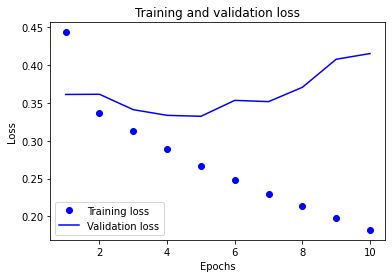

In [16]:
history_dict = history.history
print(history_dict.keys())
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

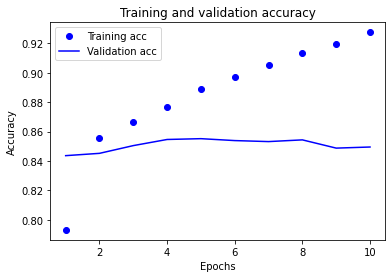

In [17]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [18]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          400000    
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 408       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 400,417
Trainable params: 400,417
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,callbacks=[es],
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
257/257 [==============================] - 1s 4ms/step - loss: 0.5126 - accuracy: 0.7701 - val_loss: 0.3780 - val_accuracy: 0.8364
Epoch 2/20
257/257 [==============================] - 1s 4ms/step - loss: 0.3387 - accuracy: 0.8537 - val_loss: 0.3527 - val_accuracy: 0.8476
Epoch 3/20
257/257 [==============================] - 1s 3ms/step - loss: 0.3006 - accuracy: 0.8724 - val_loss: 0.3510 - val_accuracy: 0.8493
Epoch 4/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2748 - accuracy: 0.8859 - val_loss: 0.3559 - val_accuracy: 0.8494
Epoch 5/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2532 - accuracy: 0.8971 - val_loss: 0.3655 - val_accuracy: 0.8482
Epoch 6/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2328 - accuracy: 0.9070 - val_loss: 0.3774 - val_accuracy: 0.8465
Epoch 7/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2138 - accuracy: 0.9166 - val_loss: 0.3940 - val_accuracy: 0.8451
Epoch 

In [20]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)


1537/1537 - 2s - loss: 0.5361 - accuracy: 0.8268
[0.5361353754997253, 0.8268201947212219]


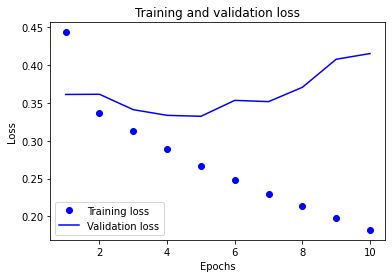

In [21]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

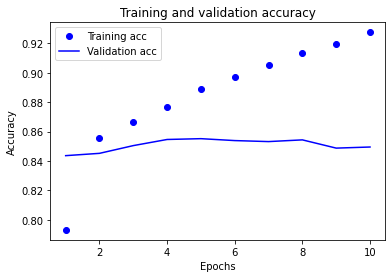

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(8000, 50)


array([-0.14660734, -0.03224965, -0.1966428 , -0.19053589, -0.06907213,
       -0.19729741, -0.1796691 , -0.12969263, -0.21674322, -0.17739828,
       -0.15551402, -0.20884721, -0.14964592, -0.07538871, -0.19489223,
       -0.13465033, -0.18884164, -0.18643686,  0.33882987, -0.1415129 ,
       -0.02668487, -0.20746118, -0.11551326, -0.19261722, -0.17213684,
       -0.22815226, -0.16716403, -0.19591315, -0.13539682, -0.09367917,
       -0.18457425, -0.18616883, -0.0740663 , -0.18126586, -0.20490734,
       -0.23568894, -0.11846176, -0.13015684, -0.17286783, -0.00645353,
       -0.03859126,  0.21061784, -0.14968616, -0.1047944 , -0.19009171,
       -0.17397314, -0.15020081, -0.1619583 , -0.16993345, -0.18346708],
      dtype=float32)

[('.', 0.9490244388580322),
 ('하', 0.9260563254356384),
 ('다', 0.8989083170890808),
 ('힘든', 0.8739859461784363),
 ('고', 0.871767520904541),
 ('로', 0.8666899800300598),
 ('평점', 0.865940272808075),
 ('님', 0.8656233549118042),
 ('재밌', 0.8599085211753845),
 ('어', 0.8594026565551758)]

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 28, 300)           2400000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 28, 16)            33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

NameError: name 'x_train' is not defined

NameError: name 'x_test' is not defined